**Construcción de dataset de análisis**

Se cargan los datasets seleccionados del Sistema de Información Turística de Argentina

In [1]:
import pandas as pd

dataset1 = "viajeros-hospedados-residentes-y-no-residentes-por-destino.csv"
datos1 = pd.read_csv(dataset1)
cant_viajeros_res_nores = datos1.iloc[:, :4]

In [3]:
dataset2 = "estadia-media-residentes-y-no-residentes-por-destino.csv"
datos2 = pd.read_csv(dataset2)
estadia_media_res_nores = datos2.iloc[:, :4]

In [5]:
dataset3 = "tasas-de-ocupacion-plazas-por-region-y-categoria.csv"
datos3 = pd.read_csv(dataset3)
tasas_ocup_plazas = datos3.iloc[:, :4]

In [7]:
dataset4 = "tasas-de-ocupacion-habitacion-por-region-y-categoria.csv"
datos4 = pd.read_csv(dataset4)
tasas_ocup_habit = datos4.iloc[:, :4]

In [9]:
dataset5 = "facturacion-total-en-pesos-por-region-y-categoria.csv"
datos5 = pd.read_csv(dataset5)
factu_region_categ = datos5.iloc[:, :4]

In [11]:
data1 = cant_viajeros_res_nores.merge(estadia_media_res_nores, on=['indice_tiempo', 'region_de_destino', 'origen_viajeros'], how='outer')

In [13]:
data2 = tasas_ocup_plazas.merge(tasas_ocup_habit, on=['indice_tiempo', 'region_de_destino', 'categoria_del_hotel'], how='outer').merge(factu_region_categ, on=['indice_tiempo', 'region_de_destino', 'categoria_del_hotel'], how='outer')

---------------------------------------

**Dataset definitivo**

In [82]:
# Se unen las dos partes del dataset definitivo, a pesar de que no todos los registros coincidan
data = data1.merge(data2, on=['indice_tiempo', 'region_de_destino'], how='outer')
# Se asegura que la columna indice_tiempo tenga el formato datetime
data['indice_tiempo'] = pd.to_datetime(data['indice_tiempo'])
data.head()

,indice_tiempo,region_de_destino,origen_viajeros,viajeros,estadia_media_en_noches,categoria_del_hotel,tasa_de_ocupacion_plazas,tasa_de_ocupacion_habitaciones,facturacion_total_en_pesos
0,2007-01-01,Buenos Aires,Residentes,401221.0,5.3,NaN,NaN,NaN,NaN
1,2007-01-01,Buenos Aires,No residentes,12889.0,3.8,NaN,NaN,NaN,NaN
2,2007-01-01,Buenos Aires,Total,NaN,5.3,NaN,NaN,NaN,NaN
3,2007-01-01,CABA,Residentes,139181.0,2.3,NaN,NaN,NaN,NaN
4,2007-01-01,CABA,No residentes,196750.0,2.4,NaN,NaN,NaN,NaN


______________________________

In [17]:
import matplotlib.pyplot as plt

**¿Cómo fue la evolución del número de viajeros residentes entre 2020 y 2024? ¿Cuáles fueron las regiones más populares en el tiempo?**

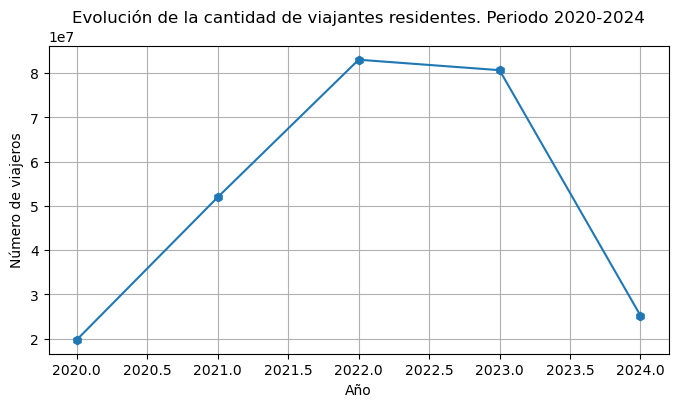

In [19]:
tiempo_filtrado = data[(data['indice_tiempo'].dt.year >= 2020) & (data['indice_tiempo'].dt.year <= 2024)]
viajeros_resid = tiempo_filtrado[tiempo_filtrado['origen_viajeros'] == 'Residentes']

# Se copia del DataFrame filtrado para evitar SettingWithCopyWarning
# viajeros_resid queda igual para solo modificar su copia

viajeros_resid = viajeros_resid.copy()
# Se agrega columna "year" basada en "indice_tiempo"
viajeros_resid['year'] = viajeros_resid['indice_tiempo'].dt.year

# Cada año tiene la suma de viajeros
viaj_x_ano = viajeros_resid.groupby('year')['viajeros'].sum()

# Gráfico
plt.figure(figsize=(8, 4))
viaj_x_ano.plot(kind='line', marker='h')
plt.title('Evolución de la cantidad de viajantes residentes. Periodo 2020-2024')
plt.xlabel('Año')
plt.ylabel('Número de viajeros')
plt.grid(True)
plt.show()

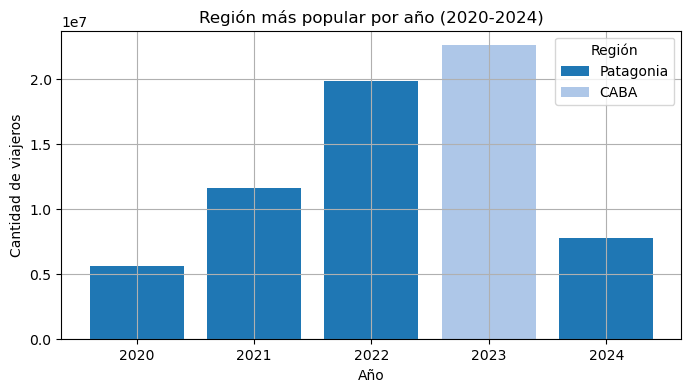

In [84]:
tiempo_filtrado = tiempo_filtrado.copy()

# Se agrega la columna 'year'
tiempo_filtrado['year'] = tiempo_filtrado['indice_tiempo'].dt.year

# Se agrupa por año y región, luego se suman los viajeros
region_x_ano_filtrado = tiempo_filtrado.groupby(['year', 'region_de_destino'])['viajeros'].sum().reset_index()

# Región más popular por año
idx_year_max_viaj = region_x_ano_filtrado.groupby('year')['viajeros'].idxmax()
regiones_populares = region_x_ano_filtrado.loc[idx_year_max_viaj]

# Gráfico
# Colores distintos para cada región
regiones = regiones_populares['region_de_destino'].unique()
colores = plt.cm.tab20(range(len(regiones)))
color_dict = dict(zip(regiones, colores))

plt.figure(figsize=(8, 4))
for year in regiones_populares['year'].unique():
    region = regiones_populares[regiones_populares['year'] == year]
    plt.bar(year, region['viajeros'].values[0], label=region['region_de_destino'].values[0], color=color_dict[region['region_de_destino'].values[0]])

# Se evitan duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Región')

plt.title('Región más popular por año (2020-2024)')
plt.xlabel('Año')
plt.ylabel('Cantidad de viajeros')
plt.xticks(regiones_populares['year'].unique())
plt.grid(True)
plt.show()

El pico de turismo de verano fue en 2022, si bien se recuerda que los datos del año actual están actualizados hasta abril. Las zonas más fuertes son la Patagonia y CABA.

**Dentro del periodo de las vacaciones de verano del 2020-2021, ¿cómo fue la tasa de ocupación hotelera? ¿El levantamiento de las etapas de la cuarentena ayudó a su incremento con el tiempo?**

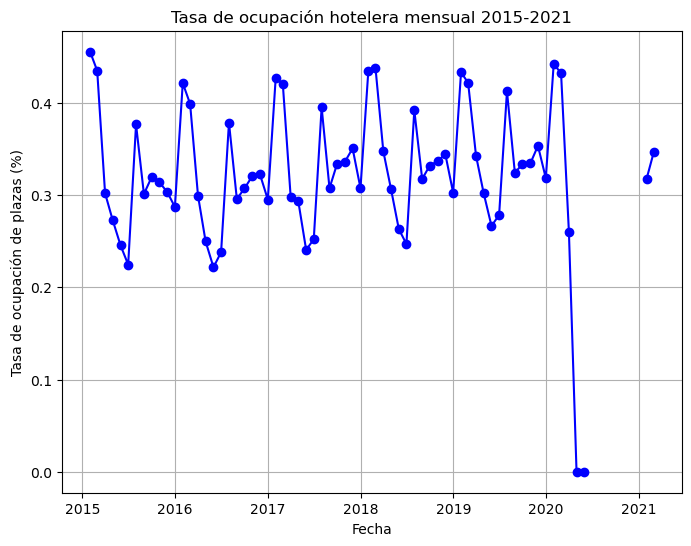

In [96]:
pre_post_cuarent_2020 = data[(data['indice_tiempo'] <= '2021-02-01') & (data['indice_tiempo'] >= '2015-01-01')]

tasa_ocup_pre2020 = pre_post_cuarent_2020.resample('M', on='indice_tiempo')['tasa_de_ocupacion_plazas'].mean()

# Gráfico de la tasa de ocupación hotelera mensual
plt.figure(figsize=(8, 6))
plt.plot(tasa_ocup_pre2020.index, tasa_ocup_pre2020.values, marker='o', linestyle='-', color='blue')
plt.title('Tasa de ocupación hotelera mensual 2015-2021')
plt.xlabel('Fecha')
plt.ylabel('Tasa de ocupación de plazas (%)')
plt.grid(True)
plt.show()


**Tener en cuenta que el turismo comienza a tener normalidad entre noviembre y diciembre de 2020. Se observa que la ocupación va creciendo de a poco, paralalamente a la apertura del turismo.

**Teniendo en cuenta el punto anterior, ¿cuál es la región del país que menos facturación tuvo durante
ese periodo? ¿Hubo algún cambio de preferencia este año?**

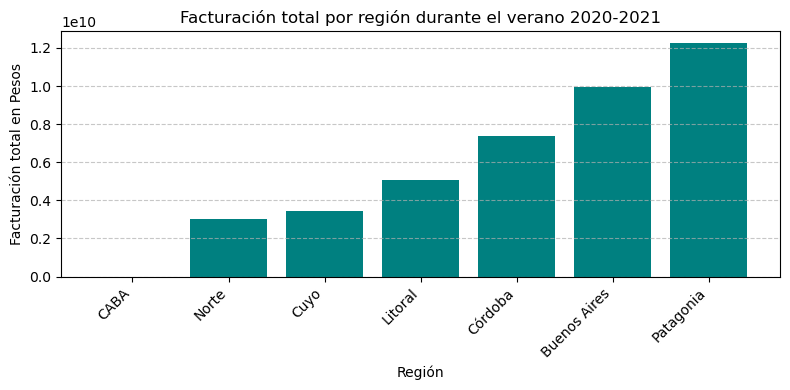

In [31]:
# Facturación por region
fact_x_region = vacac_verano_20_21.groupby('region_de_destino')['facturacion_total_en_pesos'].sum().reset_index()
region_menor_fact = fact_x_region.loc[fact_x_region['facturacion_total_en_pesos'].idxmin()]
fact_x_region = fact_x_region.sort_values(by='facturacion_total_en_pesos')

# Gráfico de la facturación total por región - verano 2020-2021
plt.figure(figsize=(8, 4))
plt.bar(fact_x_region['region_de_destino'], fact_x_region['facturacion_total_en_pesos'], color='teal')
plt.title('Facturación total por región durante el verano 2020-2021')
plt.xlabel('Región')
plt.ylabel('Facturación total en Pesos')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**CABA fue la zona que tuvo una facturación más baja. Sin embargo, la Patagonia se mantuvo fuerte. Tener en cuenta el Norte y Cuyo en siguientes análisis.

Regiones según recaudación en el verano 2024

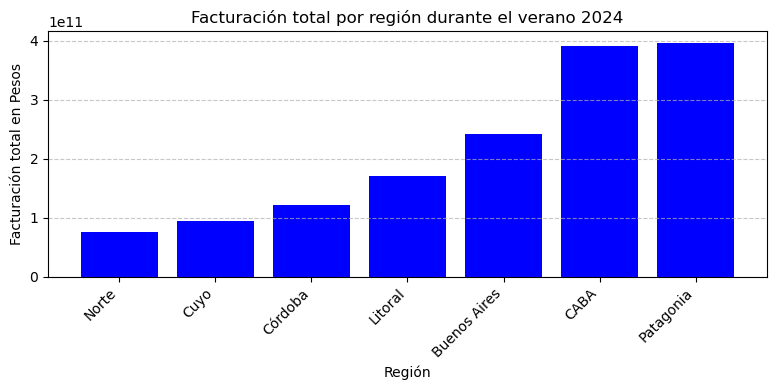

In [106]:
# Verano 2024
ocup_24 = data[(data['indice_tiempo'] >= '2024-01-01') & (data['indice_tiempo'] <= '2024-03-01')]

fact_x_region_2024 = ocup_24.groupby('region_de_destino')['facturacion_total_en_pesos'].sum().reset_index()
fact_x_region_2024 = fact_x_region_2024.sort_values(by='facturacion_total_en_pesos')

# Gráfico de la facturación total por región - verano 2024
plt.figure(figsize=(8, 4))
plt.bar(fact_x_region_2024['region_de_destino'], fact_x_region_2024['facturacion_total_en_pesos'], color='blue')
plt.title('Facturación total por región durante el verano 2024')
plt.xlabel('Región')
plt.ylabel('Facturación total en Pesos')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Hay más recaudación. CABA demostró mucha mejora. La Patagonia se mantiene como la región con más recaudación. Como se supuso, el Norte y Cuyo podrían ser dos sectores que podrían fomentarse con políticas públicas. Se podria evaluar si el Litoral es un caso similar a aquellos dos.

*Cantidad de viajeros en Cuyo, el Norte y el Litoral en el tiempo (2022-2024)*

In [108]:
periodo_2022_2024 = data[(data['indice_tiempo'] >= '2022-01-01') & (data['indice_tiempo'] <= '2024-03-01')]

# Solo se evaluará los datos relacionados a Cuyo, el Norte y el Litoral
ncl_22_24 = periodo_2022_2024[(periodo_2022_2024['region_de_destino'] == 'Cuyo') | 
                    (periodo_2022_2024['region_de_destino'] == 'Norte') |
                    (periodo_2022_2024['region_de_destino'] == 'Litoral')]

# Dataframe co tiempo, region y cant. de viajeros
viaj_x_tiempo = ncl_22_24.groupby(['indice_tiempo', 'region_de_destino'])['viajeros'].sum().unstack()

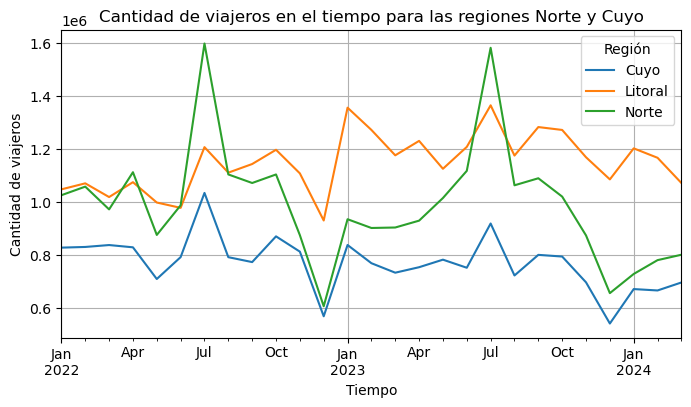

In [37]:
# Gráfico
viaj_x_tiempo.plot(kind='line', figsize=(8, 4))
plt.title('Cantidad de viajeros en el tiempo para las regiones Norte y Cuyo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de viajeros')
plt.legend(title='Región')
plt.grid(True)
plt.show()

**El Litoral recibe una cantidad de viajantes relativamente regular con el tiempo. Por otro lado, cabe destacar que la temporada más fuerte en el Norte y en Cuyo es el receso de invierno. Se recomienda aplicar promociones para la temporada de verano (sobre todo en diciembre). Remarcar la urgencia en el Norte, por sufrir caidas más marcadas.

**En el Norte y en Cuyo, ¿qué categorías de hotel muestran un crecimiento constante en facturación?**

In [39]:
# Solo se evaluarán los datos del Norte y Cuyo
norte_cuyo = ncl_22_24[ncl_22_24['region_de_destino'].isin(['Norte', 'Cuyo'])]

# Por ser datos que no aportan nada, se sacan los datos almacenados como "total"
norte_cuyo = norte_cuyo[norte_cuyo['categoria_del_hotel'] != 'Total']
hotel_nc = norte_cuyo.groupby(['indice_tiempo','region_de_destino', 'categoria_del_hotel'])['facturacion_total_en_pesos'].sum().reset_index()

In [41]:
# Se parte de la hipótesis de que diciembre es el mes más débil para Cuyo y el Norte
diciem_norte_cuyo = norte_cuyo[(norte_cuyo['indice_tiempo'].dt.month == 12)]

# Agrupar los datos por índice de tiempo, región de destino y categoría del hotel
hotel_nc = diciem_norte_cuyo.groupby(['indice_tiempo', 'region_de_destino', 'categoria_del_hotel'])['facturacion_total_en_pesos'].sum().reset_index()

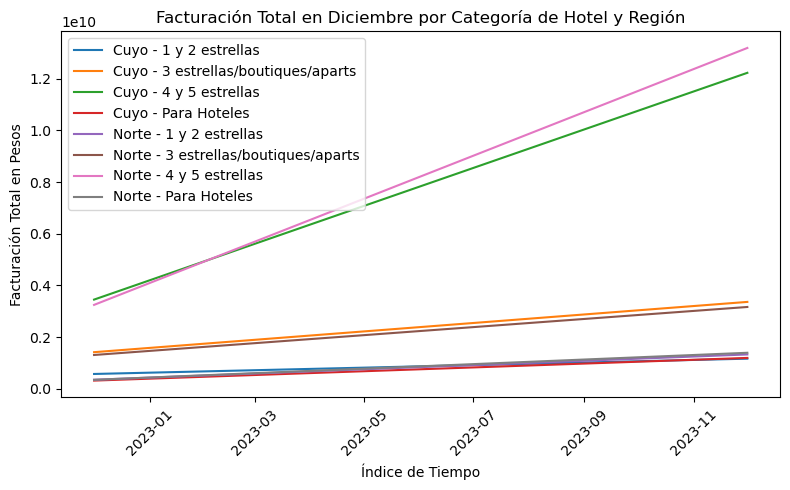

In [110]:
# Se calcula el cambio porcentual entre el valor actual y el valor anterior en facturacion_total_en_pesos para cada alojamiento
hotel_nc['crecim_fact'] = hotel_nc.groupby(['region_de_destino', 'categoria_del_hotel'])['facturacion_total_en_pesos'].pct_change()

# Gráfico separado por alojamiento
fig, ax = plt.subplots(figsize=(8, 5))

for (region, categoria), data in hotel_nc.groupby(['region_de_destino', 'categoria_del_hotel']):
    ax.plot(data['indice_tiempo'], data['facturacion_total_en_pesos'], label=f'{region} - {categoria}')

ax.set_xlabel('Índice de Tiempo')
ax.set_ylabel('Facturación total en Pesos')
ax.legend()
ax.set_title('Facturación total en diciembre por categoría de Hotel y Región')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Se observa que el fuerte tanto de Cuyo como del Norte en los meses de diciembre son los hoteles más caros (4 y 5 estrellas). Se procederá a seguir evaluando los alojamientos más baratos para detectar comportamientos más concretos.

**¿Qué tipo de viajeros reciben el Norte y Cuyo?**

In [45]:
# Se descarta el valor que no da aportes: total
norte_cuyo = norte_cuyo[norte_cuyo['origen_viajeros'] != 'Total']

# Solo se analizan los alojamientos más baratos
hotel_viaj_nc = norte_cuyo[norte_cuyo['categoria_del_hotel'].isin(['1 y 2 estrellas', '3 estrellas/boutiques/aparts', 'Para Hoteles'])]

In [47]:
hotel_viaj_nc = hotel_viaj_nc.groupby(['region_de_destino', 'origen_viajeros'])['viajeros'].sum().reset_index()

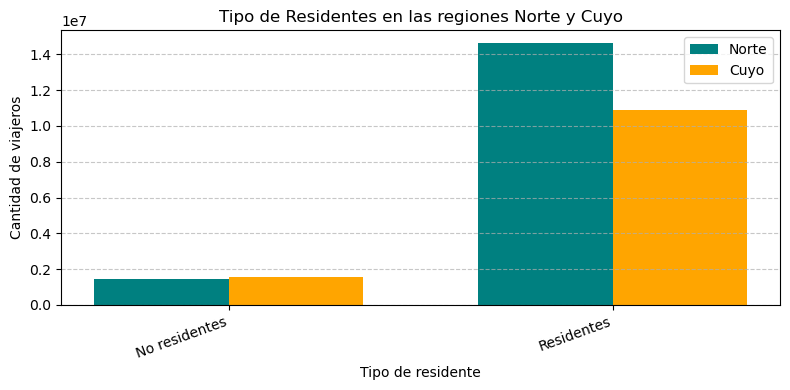

In [49]:
viaj_res_nores = hotel_viaj_nc.groupby(['origen_viajeros', 'region_de_destino']).sum().unstack()
#Se simplifican los niveles para usar bien las regiones
viaj_res_nores.columns = viaj_res_nores.columns.droplevel()

plt.figure(figsize=(8, 4))

# Barras para cada región
bar_width = 0.35
index = range(len(viaj_res_nores.index))  # Índices para las barras

# Barras para el Norte
plt.bar(index, viaj_res_nores['Norte'], bar_width, label='Norte', color='teal')

# Barras para Cuyo
plt.bar([i + bar_width for i in index], viaj_res_nores['Cuyo'], bar_width, label='Cuyo', color='orange')

# Gráfico
plt.title('Tipo de Residentes en las regiones Norte y Cuyo')
plt.xlabel('Tipo de residente')
plt.ylabel('Cantidad de viajeros')
plt.xticks([i + bar_width / 2 for i in index], viaj_res_nores.index, rotation=20, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


**Toda promoción que se quiera hacer, debe afectar a los residentes ya que son el mayor público del Norte y Cuyo.

**¿Cuáles son las tazas de ocupación hechas por residentes en cada zona y en qué tipo de alojamiento?**

In [69]:
# Solo se seleccionan los registros relacionados a los residentes
norte_cuyo_total = norte_cuyo[(norte_cuyo['region_de_destino'].isin(['Norte', 'Cuyo'])) & (norte_cuyo['origen_viajeros'] == 'Residentes')]

In [71]:
# Se calculan los promedios de ocupación de plazas (unidades hoteleras), por residentes 
variac_tempo_nc = norte_cuyo_total.set_index('indice_tiempo').groupby('region_de_destino').resample('M')['tasa_de_ocupacion_plazas'].mean().reset_index()

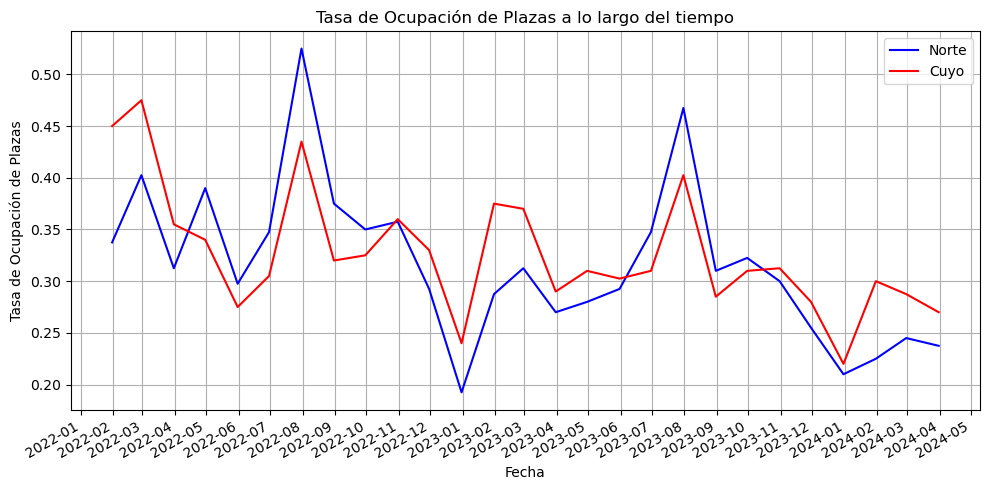

In [77]:
# Modulo para trabajar con fechas más específicas
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))

# Crear una línea para la región Norte
data_norte = variac_tempo_nc[variac_tempo_nc['region_de_destino'] == 'Norte']
plt.plot(data_norte['indice_tiempo'], data_norte['tasa_de_ocupacion_plazas'], label='Norte', color='blue')

# Crear una línea para la región Cuyo
data_cuyo = variac_tempo_nc[variac_tempo_nc['region_de_destino'] == 'Cuyo']
plt.plot(data_cuyo['indice_tiempo'], data_cuyo['tasa_de_ocupacion_plazas'], label='Cuyo', color='red')

# Configuración del gráfico
plt.title('Tasa de Ocupación de Plazas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Ocupación de Plazas')

# Configuración detallada del eje x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Marca cada mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de fecha: Año-Mes

plt.gcf().autofmt_xdate()  # Rotar fechas para mejor visibilidad

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Se confirma que los veranos son los puntos más bajos para el Norte y Cuyo, tanto en cantidad de viajeros sin distinción (visto anteriormente) como en ocupación de plazas entre residentes.

*Alojamientos de Cuyo y el Norte que podrían fortalecerse*

In [75]:
res_nc = norte_cuyo[(norte_cuyo['origen_viajeros'] != 'Total') & (norte_cuyo['origen_viajeros'] != 'No residentes')]

# Se calculan tasas de ocupación de unidades y habitaciones, además de la facturación por tipo de alojamiento
res_ocup_rc = res_nc.groupby(['region_de_destino', 'categoria_del_hotel']).agg(
    {'tasa_de_ocupacion_habitaciones': 'mean', 'tasa_de_ocupacion_plazas': 'mean', 'facturacion_total_en_pesos': 'sum'})
tazas_ocup_nc = res_ocup_rc.sort_values(by=['region_de_destino', 'facturacion_total_en_pesos'])
tazas_ocup_nc = tazas_ocup_nc.reset_index()

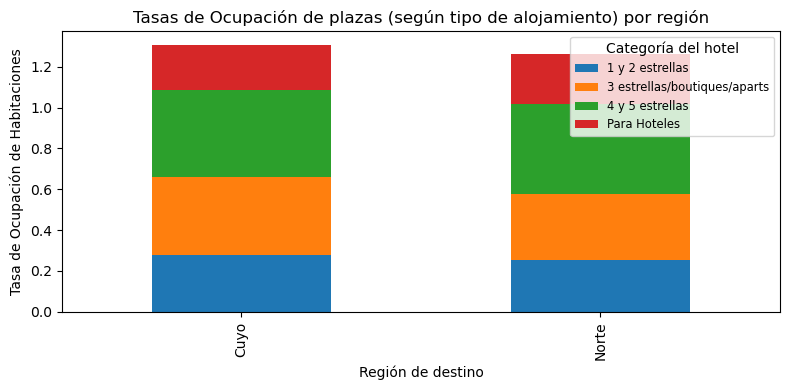

In [61]:
plt.figure(figsize=(8, 4))

tazas_ocup_nc.pivot(index='region_de_destino', columns='categoria_del_hotel', values='tasa_de_ocupacion_plazas').plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('Región de destino')
plt.ylabel('Tasa de Ocupación de Habitaciones')
plt.title('Tasas de Ocupación de plazas (según tipo de alojamiento) por región')
plt.legend(title='Categoría del hotel', fontsize='small')

plt.tight_layout()
plt.show()


Detalle importante:

- Tasa de ocupación de habitaciones (TOH): cociente entre las habitaciones o unidades
ocupadas sobre las habitaciones o unidades disponibles, en términos porcentuale.
- 
Tasa de ocupación de plazas (TOP): cociente entre plazas ocupadas sobre las plazas
disponibles, en términos porcentuales

**Conclusión**: se podrían ofrecer descuentos a residentes en la temporada de verano, sobre todo para ocupar alojamientos de 1 y 2 estrellas o parahoteles. Lo que podría conducirnos a enfocarnos a turistas jóvenes.